In [1]:
import pandas as pd
from tshistory.api import timeseries
import requests, warnings
import datetime
from datetime import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')
server = 'https://TST-QDEV-AP1.petroineos.local:5001'

In [3]:
% matplotlib inline

UsageError: Line magic function `%` not found.


## database kpler flows

In [ ]:
import pandas as pd
import requests
from tshistory.api import timeseries
# from saturn_server.cross.helpers import safe_register_formula


In [ ]:
def ag_get_data(query, server):
    params = {"Database": "OIL", "Query": query}
    resp = requests.post(f"{server}/genericdata/Fetch/",
                         json=params, verify=False)
    jsonResult = resp.json()
    data = pd.DataFrame(jsonResult)
    return data

In [ ]:
oecd_europe = ('Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands')
country_list = ['United States','Nigeria', 'Angola', 'Brazil', 'Libya', 'Algeria', 'Saudi Arabia', 'Iraq', 'Iran']
subcontinent_list = ['Western Africa', 'South America', 'Northern America', 'Northern Africa', 'Middle East']

In [ ]:
oecd_exports_query = f'''select voyage_start date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
where (origin_country_name in {oecd_europe} and  zone_origin_name != 'Ceyhan')
and destination_country_name not in {oecd_europe}
group by voyage_start
order by voyage_start desc
'''

In [ ]:
oecd_imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
where (origin_country_name not in {oecd_europe} or zone_origin_name = 'Ceyhan')
and destination_country_name in {oecd_europe}
group by voyage_end
order by voyage_end desc
'''

In [ ]:
def aggregate_daily_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('D').sum().astype(float)
    return df_grouped['volume']

In [ ]:
def aggregate_monthly_kbd(df):
    df.index = pd.to_datetime(df.date)
    df_grouped = df.resample('MS').sum().astype(float)
    df_grouped['volume'] = df_grouped['volume']/(df_grouped.index.daysinmonth*1000)
    return df_grouped['volume']

In [ ]:
def clean_names(str_list):
    new_list = []
    for i in range(len(str_list)):
        new_list.append(str_list[i].lower())
        new_list[i] = new_list[i].replace(' ','_')
    return new_list

In [ ]:
def db_country_imports(origin, server):
    country_imports_query = f'''select voyage_end date, sum(cargo_origin_barrels_split_by_product) volume from oil.dbo.KplerTrades 
    where origin_country_name = '{origin}' and destination_country_name in {oecd_europe}
    group by voyage_end
    order by voyage_end desc
    '''

    # ts = aggregate_monthly_kbd(ag_get_data(country_imports_query))
#     ts_daily = aggregate_daily_kbd(ag_get_data(country_imports_query, server))
    ts_daily = ag_get_data(country_imports_query, server)
    return ts_daily

In [ ]:
def upload_kpler_country_loop(ctry_list, tsa, server):
    names = clean_names(ctry_list)
    for c, n in zip(ctry_list, names):
        ts = db_country_imports(c, server)
        name = f'crude.kpler.{n}.oecd_europe.imports.kbd.daily'
#         tsa.update(name, ts, 'Syed Ahmad')
        print(f'{c} uploaded')
    return print (f'{len(ctry_list)} series uploaded')

In [ ]:
if __name__ == '__main__':
    tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')
    server = 'https://TST-QDEV-AP1.petroineos.local:5001'
    upload_kpler(tsa, server)
    upload_kpler_country_loop(country_list, tsa, server)

## get request

In [64]:
import pandas as pd
import requests
from tshistory.api import timeseries
import statsmodels.api as sm

In [65]:
from statsmodels.tsa.arima_model import ARIMA

In [67]:
tsa = timeseries(URI)

In [69]:
oecd_imports = 'crude.kpler.oecd_europe.imports.kbd.monthly'
URI = 'http://tst-qdev-ap9.petroineos.local/api'
oecd_runs = 'crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast'
oecd_production = 'crude.iea.oecd_europe.production.kbd.monthly.forecast'
druz = 'crude.petroineos.russia.oecd_europe.pipe_exports.kbd.monthly.forecast.full'
net_sh = 'crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast'
exp = 'crude.kpler.oecd_europe.exports.kbd.monthly.forecast.full'

In [80]:
oecd_imports_series = tsa.get(oecd_imports)
oecd_runs_series  = tsa.get(oecd_runs)
oecd_prod_series = tsa.get(oecd_production)
druzbha = tsa.get(druz)
net_short = tsa.get(net_sh)
exports = tsa.get(exp)
short = net_short + exports

In [72]:
correlation = pd.merge(oecd_imports_series, net_short, right_index=True, left_index=True)

In [332]:
correlation_hist = correlation['2013-02-01':'2022-05-01'].copy()

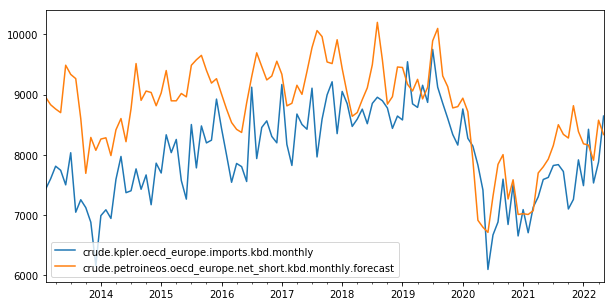

In [333]:
correlation_hist.plot(kind='line', figsize=(10,5))

In [334]:
# modeling OLS
x = correlation_hist['crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast']
y = correlation_hist['crude.kpler.oecd_europe.imports.kbd.monthly']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     crude.kpler.oecd_europe.imports.kbd.monthly   R-squared:                       0.475
Model:                                                     OLS   Adj. R-squared:                  0.471
Method:                                          Least Squares   F-statistic:                     99.72
Date:                                         Wed, 15 Jun 2022   Prob (F-statistic):           4.21e-17
Time:                                                 23:08:16   Log-Likelihood:                -862.19
No. Observations:                                          112   AIC:                             1728.
Df Residuals:                                              110   BIC:                             1734.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
const                                                        2187.4913    585.334      3.737      0.000    1027.497    3347.486
crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast     0.6648      0.067      9.986      0.000       0.533       0.797
==============================================================================
Omnibus:                        0.838   Durbin-Watson:                   1.024
Prob(Omnibus):                  0.658   Jarque-Bera (JB):                0.945
Skew:                          -0.140   Prob(JB):                        0.623
Kurtosis:                       2.648   Cond. No.                     1.01e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# # old correlations vs runs thorughput
# correlation_hist['y'] = correlation_hist['crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast']*0.7157 + -334.1494

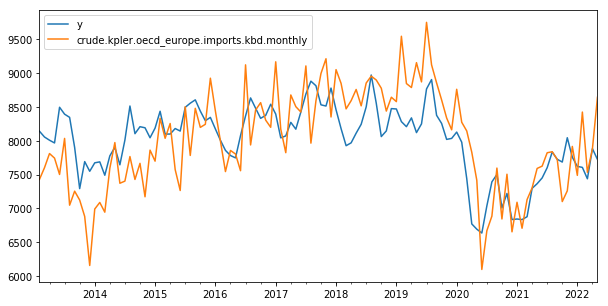

In [337]:
correlation_hist['y'] = correlation_hist['crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast']*0.6702 + 2137.2517
correlation_hist.plot(kind='line', figsize=(10,5), y=['y', 'crude.kpler.oecd_europe.imports.kbd.monthly'])

In [15]:
net_short_ols_id = 'crude.kpler.oecd_europe.imports.kbd.monthly.forecast.ols'
net_short_ols = tsa.get(net_short_ols_id)
correlation_check = correlation_hist.merge(net_short_ols, right_index=True, left_index=True)

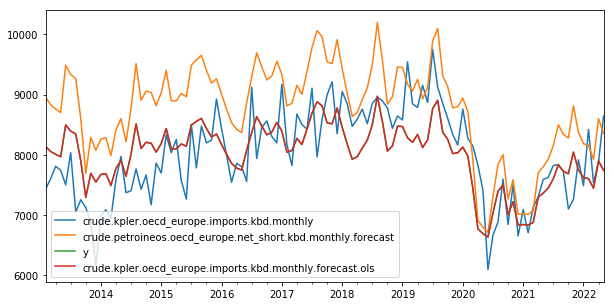

In [19]:
correlation_check.plot(kind='line', figsize=(10,5))

In [345]:
new_corr = correlation_hist.merge(druzbha, left_index=True, right_index=True)

In [348]:
new_corr.head()

crude.kpler.oecd_europe.imports.kbd.monthly  \
2013-02-01                                  7429.574893   
2013-03-01                                  7602.070548   
2013-04-01                                  7812.009767   
2013-05-01                                  7744.486452   
2013-06-01                                  7502.783500   

            crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast  \
2013-02-01                                        8959.549286             
2013-03-01                                        8832.135806             
2013-04-01                                        8761.146333             
2013-05-01                                        8700.837742             
2013-06-01                                        9487.591333             

                      y  \
2013-02-01  8141.941631   
2013-03-01  8056.549117   
2013-04-01  8008.971973   
2013-05-01  7968.553155   
2013-06-01  8495.835412   

            crude.petroineos.russia.oecd_europe.pipe_exports.kbd.monthly.forecast.full  \
2013-02-01                                         993.976796                            
2013-03-01                                         967.914677                            
2013-04-01                                         950.226993                            
2013-05-01                                        1009.196765                            
2013-06-01                                         997.180530                            

            druzbha_short  
2013-02-01    7965.572489  
2013-03-01    7864.221129  
2013-04-01    7810.919340  
2013-05-01    7691.640977  
2013-06-01    8490.410803

In [347]:
new_corr['druzbha_short'] = new_corr['crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast'] - new_corr['crude.petroineos.russia.oecd_europe.pipe_exports.kbd.monthly.forecast.full']

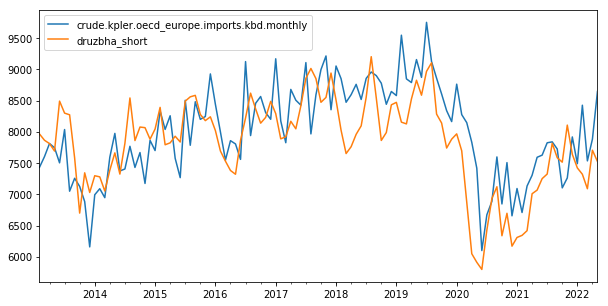

In [353]:
new_corr.plot(kind='line', figsize=(10,5), y=['crude.kpler.oecd_europe.imports.kbd.monthly', 'druzbha_short'])

In [355]:
# modeling OLS with druzbha
x = new_corr['druzbha_short']
y = new_corr['crude.kpler.oecd_europe.imports.kbd.monthly']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     crude.kpler.oecd_europe.imports.kbd.monthly   R-squared:                       0.506
Model:                                                     OLS   Adj. R-squared:                  0.502
Method:                                          Least Squares   F-statistic:                     112.7
Date:                                         Wed, 15 Jun 2022   Prob (F-statistic):           1.49e-18
Time:                                                 23:21:09   Log-Likelihood:                -858.82
No. Observations:                                          112   AIC:                             1722.
Df Residuals:                                              110   BIC:                             1727.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2297.3263    540.364      4.251      0.000    1226.452    3368.201
druzbha_short     0.7309      0.069     10.617      0.000       0.594       0.867
==============================================================================
Omnibus:                        0.519   Durbin-Watson:                   1.102
Prob(Omnibus):                  0.772   Jarque-Bera (JB):                0.661
Skew:                          -0.132   Prob(JB):                        0.719
Kurtosis:                       2.732   Cond. No.                     8.60e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [357]:
new_corr['y_new'] = new_corr['druzbha_short']*0.7309 + 2297.3293

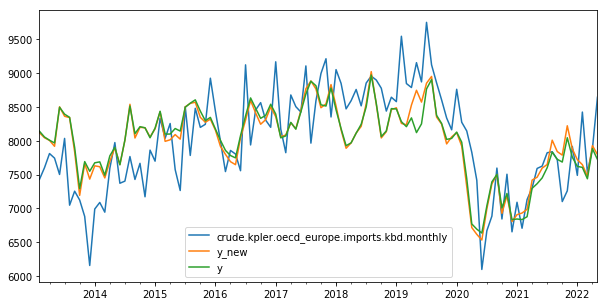

In [359]:
new_corr.plot(kind='line', figsize=(10,5), y=['crude.kpler.oecd_europe.imports.kbd.monthly', 'y_new', 'y'])

In [362]:
new_corr.head()

crude.kpler.oecd_europe.imports.kbd.monthly  \
2013-02-01                                  7429.574893   
2013-03-01                                  7602.070548   
2013-04-01                                  7812.009767   
2013-05-01                                  7744.486452   
2013-06-01                                  7502.783500   

            crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast  \
2013-02-01                                        8959.549286             
2013-03-01                                        8832.135806             
2013-04-01                                        8761.146333             
2013-05-01                                        8700.837742             
2013-06-01                                        9487.591333             

                      y  \
2013-02-01  8141.941631   
2013-03-01  8056.549117   
2013-04-01  8008.971973   
2013-05-01  7968.553155   
2013-06-01  8495.835412   

            crude.petroineos.russia.oecd_europe.pipe_exports.kbd.monthly.forecast.full  \
2013-02-01                                         993.976796                            
2013-03-01                                         967.914677                            
2013-04-01                                         950.226993                            
2013-05-01                                        1009.196765                            
2013-06-01                                         997.180530                            

            druzbha_short        y_new  
2013-02-01    7965.572489  8119.366232  
2013-03-01    7864.221129  8045.288523  
2013-04-01    7810.919340  8006.330246  
2013-05-01    7691.640977  7919.149690  
2013-06-01    8490.410803  8502.970556

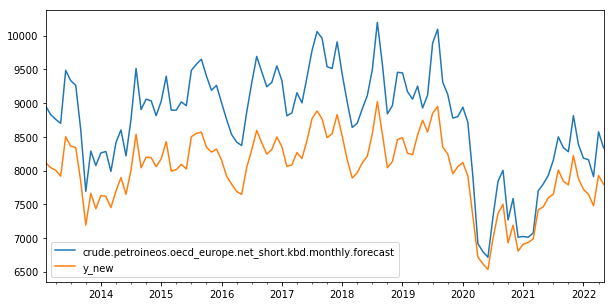

In [363]:
new_corr.plot(kind='line', figsize=(10,5), y=['crude.petroineos.oecd_europe.net_short.kbd.monthly.forecast', 'y_new'])

### forecasting imports with exports accounted for

<AxesSubplot:>

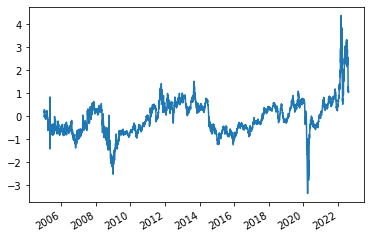

In [104]:
spread.plot()

In [94]:
shrt = exports + net_short
short = pd.DataFrame(shrt)
short.rename(columns={0:'short'}, inplace=True)
imports = pd.DataFrame(oecd_imports_series)

In [105]:
imports_corr = imports.merge(short, left_index=True, right_index=True)
imports_corr2 = imports_corr.merge(spread, left_index=True, right_index=True)

In [108]:
imports_corr2

crude.kpler.oecd_europe.imports.kbd.monthly        short  \
2013-02-01                                  7429.574893  8150.420025   
2013-03-01                                  7602.070548  8240.788161   
2013-05-01                                  7744.486452  8003.542397   
2013-07-01                                  8035.510258  8475.790535   
2013-08-01                                  7048.905194  8439.112574   
...                                                 ...          ...   
2022-03-01                                  7534.150065  7361.430532   
2022-04-01                                  7290.143533  7971.923800   
2022-06-01                                  8549.815800  8559.092238   
2022-07-01                                  8292.827871  7614.275220   
2022-08-01                                  7502.718065  8177.174643   

            price.platts.ice_brent_swap_spread.m01.usd_bbl.daily  
2013-02-01                                               0.80     
2013-03-01                                               0.79     
2013-05-01                                               0.30     
2013-07-01                                               0.50     
2013-08-01                                               0.64     
...                                                       ...     
2022-03-01                                               3.46     
2022-04-01                                               1.66     
2022-06-01                                               2.64     
2022-07-01                                               3.04     
2022-08-01                                               1.66     

[74 rows x 3 columns]

<AxesSubplot:>

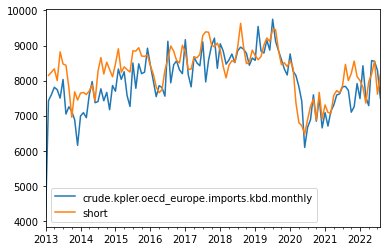

In [99]:
imports_corr[:'2022-08-01'].plot()

In [109]:
training_range = imports_corr2['2013-02-01':'2022-08-01']

In [103]:
# modeling imports with exports
x = training_range['short']
y = training_range['crude.kpler.oecd_europe.imports.kbd.monthly']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     crude.kpler.oecd_europe.imports.kbd.monthly   R-squared:                       0.573
Model:                                                     OLS   Adj. R-squared:                  0.569
Method:                                          Least Squares   F-statistic:                     151.7
Date:                                         Mon, 15 Aug 2022   Prob (F-statistic):           1.29e-22
Time:                                                 16:56:32   Log-Likelihood:                -872.92
No. Observations:                                          115   AIC:                             1750.
Df Residuals:                                              113   BIC:                             1755.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1054.0748    566.440      1.861      0.065     -68.146    2176.295
short          0.8412      0.068     12.315      0.000       0.706       0.976
==============================================================================
Omnibus:                        0.242   Durbin-Watson:                   1.337
Prob(Omnibus):                  0.886   Jarque-Bera (JB):                0.344
Skew:                          -0.102   Prob(JB):                        0.842
Kurtosis:                       2.827   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
# modeling imports with structure + exp
x = training_range[['short', 'price.platts.ice_brent_swap_spread.m01.usd_bbl.daily']]
y = training_range['crude.kpler.oecd_europe.imports.kbd.monthly']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     crude.kpler.oecd_europe.imports.kbd.monthly   R-squared:                       0.547
Model:                                                     OLS   Adj. R-squared:                  0.535
Method:                                          Least Squares   F-statistic:                     42.95
Date:                                         Mon, 15 Aug 2022   Prob (F-statistic):           5.96e-13
Time:                                                 17:04:13   Log-Likelihood:                -563.44
No. Observations:                                           74   AIC:                             1133.
Df Residuals:                                               71   BIC:                             1140.
Df Model:                                                    2                                         
Covariance Type:                                     nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                 1672.9903    684.429      2.444      0.017     308.278    3037.703
short                                                    0.7664      0.083      9.257      0.000       0.601       0.932
price.platts.ice_brent_swap_spread.m01.usd_bbl.daily    -6.3104     65.794     -0.096      0.924    -137.500     124.879
==============================================================================
Omnibus:                        0.366   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.833   Jarque-Bera (JB):                0.533
Skew:                           0.118   Prob(JB):                        0.766
Kurtosis:                       2.657   Cond. No.                     9.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Forecasting exports

In [51]:
import math
import numpy as np

In [46]:
spread = tsa.get('price.platts.ice_brent_swap_spread.m01.usd_bbl.daily')
exp_m = tsa.get('crude.kpler.oecd_europe.exports.kbd.monthly')
exp = tsa.get('crude.kpler.oecd_europe.exports.kbd.daily')
spread_m = spread.resample('MS').mean()
intermonth = tsa.get('crude.petroineos.ice_brent_intermonth_spread.usd_bbl')

In [44]:
corr = pd.merge(exp, spread, left_index=True, right_index=True)
corr_m = pd.merge(exp_m, spread_m, left_index=True, right_index=True)

In [38]:
corr_7mav = corr.rolling(14).mean()
corr_test = corr_7mav.dropna()

In [45]:
corr_m.to_csv('test.csv')

In [32]:
x = corr['price.platts.ice_brent_swap_spread.m01.usd_bbl.daily']
y = corr['crude.kpler.oecd_europe.exports.kbd.monthly']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         OLS Regression Results                                        
=======================================================================================================
Dep. Variable:     crude.kpler.oecd_europe.exports.kbd.monthly   R-squared:                       0.059
Model:                                                     OLS   Adj. R-squared:                  0.051
Method:                                          Least Squares   F-statistic:                     7.162
Date:                                         Mon, 15 Aug 2022   Prob (F-statistic):            0.00855
Time:                                                 13:45:36   Log-Likelihood:                -756.71
No. Observations:                                          116   AIC:                             1517.
Df Residuals:                                              114   BIC:                             1523.
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                  447.3210     15.640     28.602      0.000     416.339     478.303
price.platts.ice_brent_swap_spread.m01.usd_bbl.daily   -52.6842     19.687     -2.676      0.009     -91.684     -13.685
==============================================================================
Omnibus:                       10.620   Durbin-Watson:                   0.948
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.935
Skew:                           0.647   Prob(JB):                      0.00422
Kurtosis:                       3.768   Cond. No.                         1.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
exp_fcast = 442.22 - 253.4*np.log(intermonth)

In [63]:
tsa.update('crude.kpler.oecd_europe.exports.kbd.monthly.forecast.log', exp_fcast, 'Syed Ahmad')

2022-09-01     406.804324
2022-10-03     427.454659
2022-11-01     434.729800
2022-12-01     463.348900
2023-01-02     480.438520
                 ...     
2028-09-01    1201.338558
2028-10-02    1082.239638
2028-11-01    1330.781771
2028-12-01    1201.338558
2029-01-02    1201.338558
Name: crude.kpler.oecd_europe.exports.kbd.monthly.forecast.log, Length: 77, dtype: float64

## regression and forecasting of regional flows

In [4]:
from kpler.sdk.configuration import Configuration
from kpler.sdk import Platform
from tshistory.api import timeseries
config = Configuration(Platform.Liquids, "syed.ahmad@petrochinaintl.co.uk", "petroineos")

from kpler.sdk.resources.flows import Flows
from kpler.sdk import FlowsDirection, FlowsSplit, FlowsPeriod, FlowsMeasurementUnit
flows_client = Flows(config)

In [5]:
import os
import datetime
from datagenic_rest_client.datagenic import DataGenic

datagenic_rest_server = "http://lon-qdev-ap11"
tsa = timeseries('http://tst-qdev-ap9.petroineos.local/api')

In [6]:
bonny_id = "model://PLATTS_RI/PLATTS.CRUDE.RI.AAGXL00"

In [7]:
brent_m1 = tsa.get('price.platts.ice_brent_swap.m01.usd_bbl.daily')
brent_m2 = tsa.get('price.platts.ice_brent_swap.m02.usd_bbl.daily')
brent_m3 = tsa.get('price.platts.ice_brent_swap.m03.usd_bbl.daily')

In [8]:
spread = pd.DataFrame(brent_m2 - brent_m3)
spread.columns = ['spread']

In [9]:
def get_series(modelid):
    from_date = datetime.date(2013, 1, 1)
    to_date = datetime.date(2022, 7, 20)

    c = DataGenic(url_rest_wrapper=datagenic_rest_server, datagenic_url=os.environ["datagenicserver"],
                  datagenic_username=os.environ["datagenicusername"], datagenic_password=os.environ["datagenicpassword"])


    df=c.get_time_series(model_url=modelid,from_date=from_date, to_date=to_date)
#     df.reset_index(inplace=True)
#     df.rename(columns={'Time':'Date'}, inplace=True)
#     df.set_index('Date')
    return df

In [10]:
def get_flow(prod=['Crude/Condensate'], origin=[]):
    df = flows_client.get(
    with_intra_country=False,
    products=prod,
    from_zones=origin,
    flow_direction=[FlowsDirection.Export],
    split=[FlowsSplit.DestinationContinents],
#     split=[FlowsSplit.Total],
    granularity=[FlowsPeriod.Monthly],
    unit=[FlowsMeasurementUnit.KBD],
    start_date=dt(2013,1,1),
#     end_date=today,
    )
    df.drop(columns='Period End Date', inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [11]:
def merge_corr(df1, df2):
    merged_df = pd.merge(df1, df2,  left_index=True, right_index=True)
    return merged_df

In [12]:
def plot(df):
    df.plot(kind='scatter', x='Europe', y='PRICE')
    ax1 = df.plot(kind='line', y=['Europe'])
    df.plot(kind='line', y=['PRICE'], secondary_y=True, ax=ax1)

In [36]:
bonny_diff = get_series(bonny_id).resample('MS').mean()

In [24]:
waf_exp = get_flow(origin='Western Africa')
waf_pct = waf_exp.div(waf_exp.sum(axis=1), axis=0)

In [59]:
# capacity vs flows

In [74]:
cap_diff = merge_corr(cap_corr,bonny_diff)

In [68]:
capacity = tsa.get('oil.petroineos.oecd_europe.cdu.available_capacity.kbd.monthly.full')
tput = tsa.get('crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast')

In [71]:
cap_corr = merge_corr(waf_pct, tput)

<AxesSubplot:label='3522b22d-0924-438b-92e3-ddbbb1b1ed09'>

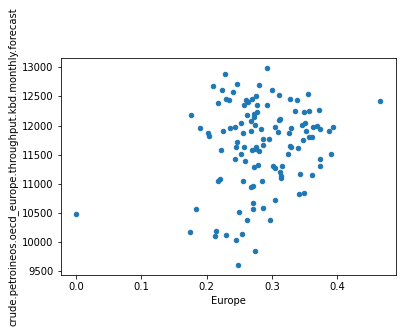

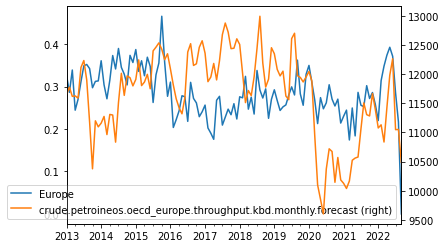

In [72]:
cap_corr.plot(kind='scatter', x='Europe', y='crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast')
ax1 = cap_corr.plot(kind='line', y=['Europe'])
cap_corr.plot(kind='line', y=['crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast'], secondary_y=True, ax=ax1)

In [76]:
x = cap_diff[['crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast', 'PRICE']]
y = cap_diff['Europe']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Europe   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     10.17
Date:                Wed, 27 Jul 2022   Prob (F-statistic):           8.71e-05
Time:                        12:52:30   Log-Likelihood:                 183.47
No. Observations:                 115   AIC:                            -360.9
Df Residuals:                     112   BIC:                            -352.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
const                                                            0.2235      0.076      2.927      0.004       0.072       0.375
crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast  4.344e-06    6.6e-06      0.658      0.512   -8.74e-06    1.74e-05
PRICE                                                            0.0140      0.003      4.137      0.000       0.007       0.021
==============================================================================
Omnibus:                        4.582   Durbin-Watson:                   0.956
Prob(Omnibus):                  0.101   Jarque-Bera (JB):                3.968
Skew:                           0.398   Prob(JB):                        0.138
Kurtosis:                       3.442   Cond. No.                     1.92e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# diff to dated

In [40]:
bonny_corr = merge_corr(waf_pct, bonny_diff)

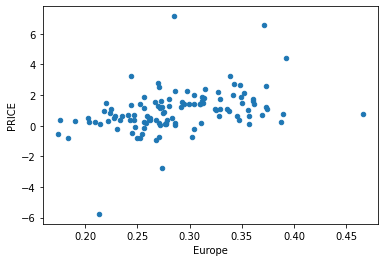

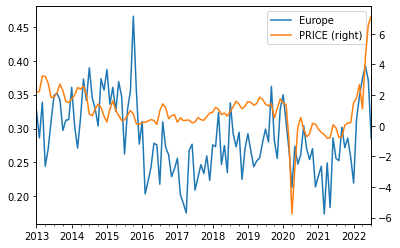

In [47]:
plot(bonny_corr)

<AxesSubplot:xlabel='Date'>

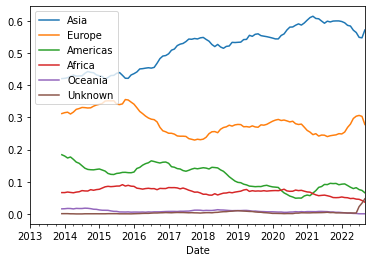

In [51]:
waf_pct.rolling(12).mean().plot()

In [108]:
waf_30mav = waf_exp.rolling(30).mean()
waf_30mav_pct = waf_30mav.div(waf_30mav.sum(axis=1), axis=0)

In [109]:
spread_30mav = spread.rolling(30).mean()
waf_corr_mav = pd.merge(waf_30mav_pct, spread_30mav, left_index=True, right_index=True)

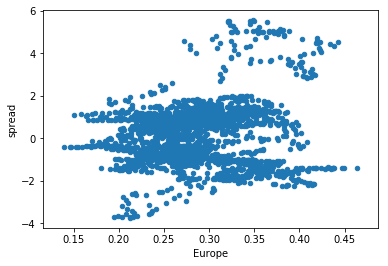

In [110]:
waf_corr_mav.plot(kind='scatter', x='Europe', y='spread')

In [111]:
ax = waf_corr_mav.plot(kind='line', y=['Europe'])
waf_corr_mav.plot(kind='line', y=['spread'], secondary_y=True, ax=ax)

### month average

In [151]:
def month_av(df):
    df_pct = df.div(df.sum(axis=1), axis=0)
    spread_ms = spread.resample('MS').mean()
    df_corr = df_pct.merge(spread_ms, how='left', left_index=True, right_index=True)
    
    df_corr.plot(kind='scatter', x='Europe', y='spread')
    ax1 = df_corr.plot(kind='line', y=['Europe'])
    df_corr.plot(kind='line', y=['spread'], secondary_y=True, ax=ax1)
    
    x = df_corr['Europe']
    y = df_corr['spread']
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    
    return model.summary()

C:\conda\envs\tsa\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\conda\envs\tsa\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\conda\envs\tsa\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\conda\envs\tsa\lib\site-packages\scipy\stats\stats.py:1408: RuntimeWarning: invalid value encountered in less
  term2 = np.where(denom < 0, term1, np.power((1-2.0/A)/denom, 1/3.0))


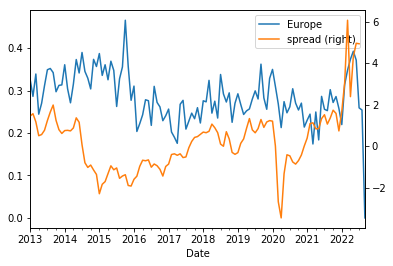

In [152]:
waf = month_av(waf_exp)

In [146]:
waf

Asia    Europe  Americas    Africa   Oceania   Unknown
Date                                                                  
2013-01-01  0.442096  0.327170  0.143926  0.062774  0.024035  0.000000
2013-02-01  0.420573  0.286249  0.220251  0.065945  0.006982  0.000000
2013-03-01  0.433616  0.338924  0.136487  0.069199  0.016393  0.005381
2013-04-01  0.401606  0.244346  0.245894  0.084580  0.022766  0.000808
2013-05-01  0.408620  0.270022  0.255821  0.052207  0.009470  0.003860
...              ...       ...       ...       ...       ...       ...
2022-05-01  0.475833  0.392546  0.086116  0.045505  0.000000  0.000000
2022-06-01  0.485475  0.371695  0.108768  0.003587  0.007090  0.023385
2022-07-01  0.388118  0.259147  0.058282  0.067212  0.000000  0.227241
2022-08-01  0.575607  0.254154  0.015472  0.015615  0.000000  0.139152
2022-09-01  0.800058  0.000000  0.000000  0.000000  0.000000  0.199942

[117 rows x 6 columns]

In [34]:
waf_exp_pct = waf_exp.div(waf_exp.sum(axis=1), axis=0)

In [75]:
spread_ms = spread.resample('MS').mean()
waf_corr = pd.merge(waf_exp_pct, spread_ms, left_index=True, right_index=True)

In [76]:
waf_corr.plot(kind='scatter', x='Europe', y='spread')

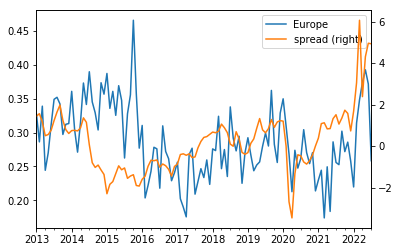

In [77]:
ax = waf_corr.plot(kind='line', y=['Europe'])
waf_corr.plot(kind='line', y=['spread'], secondary_y=True, ax=ax)

In [80]:
# modeling OLS with druzbha
x = waf_corr['Europe']
y = waf_corr['spread']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.627
Date:                Tue, 26 Jul 2022   Prob (F-statistic):              0.205
Time:                        16:19:53   Log-Likelihood:                -206.59
No. Observations:                 115   AIC:                             417.2
Df Residuals:                     113   BIC:                             422.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7162      0.751     -0.954      0.342      -2.203       0.771
Europe         3.2762      2.568      1.276      0.205      -1.812       8.364
==============================================================================
Omnibus:                       20.934   Durbin-Watson:                   0.231
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.085
Skew:                           0.788   Prob(JB):                     8.85e-09
Kurtosis:                       5.293   Cond. No.                         20.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### spreads modelling

In [13]:
spread = pd.DataFrame(brent_m1 - brent_m2)
spread.columns = ['spread']
spread_ms = spread.resample('MS').mean()

In [14]:
indicator = tsa.get('crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast')

In [15]:
corr = pd.merge(indicator, spread_ms, left_index=True, right_index=True).dropna()

In [16]:
# modeling OLS with indicator
x = corr['crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast']
y = corr['spread']
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 spread   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     76.64
Date:                Wed, 02 Nov 2022   Prob (F-statistic):           1.55e-15
Time:                        16:14:28   Log-Likelihood:                -182.41
No. Observations:                 180   AIC:                             368.8
Df Residuals:                     178   BIC:                             375.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================================================
                                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                -2.6552      0.311     -8.545      0.000      -3.268      -2.042
crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast     0.1810      0.021      8.754      0.000       0.140       0.222
==============================================================================
Omnibus:                       11.369   Durbin-Watson:                   0.468
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.582
Skew:                           0.430   Prob(JB):                     0.000682
Kurtosis:                       4.098   Cond. No.                         93.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
corr['y'] = -2.6693 +0.18*corr['crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast']

<AxesSubplot:>

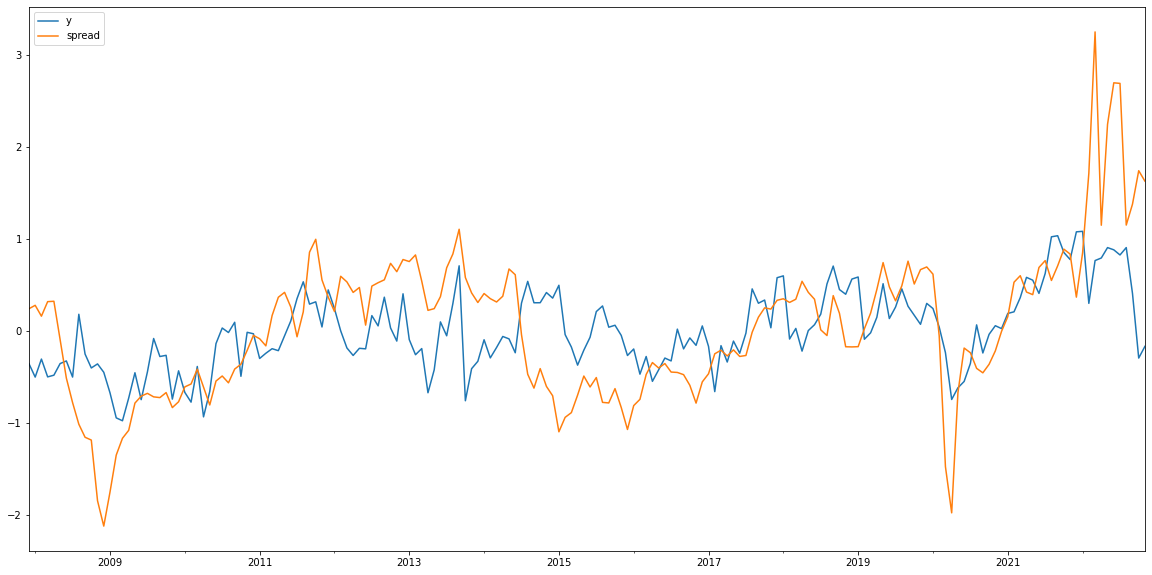

In [18]:
corr.plot(y=['y', 'spread'], figsize=(20,10))

In [19]:
m1m2_fcast = -2.6693 +0.18*indicator

In [20]:
m1m2_fcast.tail(20).plot()

<AxesSubplot:>

In [21]:
fwd = tsa.get('crude.petroineos.ice_brent_intermonth_spread.usd_bbl')

In [22]:
call = pd.merge(fwd,m1m2_fcast.shift(2), left_index=True, right_index=True)

In [23]:
call.rename(columns={'crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast':'call on spread'}, inplace=True)

In [24]:
call.plot(figsize=(10,5))

<AxesSubplot:>

In [25]:
call

crude.petroineos.ice_brent_intermonth_spread.usd_bbl  \
2022-11-01                                               1.04      
2022-12-01                                               1.00      
2023-02-01                                               0.82      
2023-03-01                                               0.73      
2023-05-01                                               0.56      
2023-06-01                                               0.58      
2023-08-01                                               0.53      
2023-09-01                                               0.47      
2023-11-01                                               0.54      

            call on spread  
2022-11-01        0.562140  
2022-12-01        0.528486  
2023-02-01        0.614422  
2023-03-01        0.977028  
2023-05-01        0.650424  
2023-06-01        0.456376  
2023-08-01        0.352067  
2023-09-01        0.602319  
2023-11-01        0.350596

In [21]:
m1m2_fcast.shift(2)

2007-12-01         NaN
2008-01-01         NaN
2008-02-01   -0.355678
2008-03-01   -0.501868
2008-04-01   -0.305874
                ...   
2023-07-01    0.357318
2023-08-01    0.209659
2023-09-01    0.443757
2023-10-01    0.550992
2023-11-01    0.091080
Name: crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast, Length: 192, dtype: float64

In [22]:
call

crude.petroineos.ice_brent_intermonth_spread.usd_bbl  \
2022-09-01                                               1.52      
2022-11-01                                               1.10      
2022-12-01                                               0.85      
2023-02-01                                               0.71      
2023-03-01                                               0.63      
2023-05-01                                               0.55      
2023-06-01                                               0.54      
2023-08-01                                               0.47      
2023-09-01                                               0.47      
2023-11-01                                               0.57      

            call on spread  
2022-09-01        0.804192  
2022-11-01        0.441753  
2022-12-01        0.488060  
2023-02-01        0.517629  
2023-03-01        0.897414  
2023-05-01        0.547813  
2023-06-01        0.342603  
2023-08-01        0.209659  
2023-09-01        0.443757  
2023-11-01        0.091080

### playaround

In [26]:
true_imp = tsa.get('crude.petroineos.oecd_europe.true_import_requirement.days_supply.monthly.forecast')
tput = tsa.get('crude.petroineos.oecd_europe.throughput.kbd.monthly.forecast')
spot_imp = tsa.get('crude.petroineos.oecd_europe.spot_import_requirement.kbd.monthly.forecast')
stcks = tsa.get('crude.iea.oecd_europe.ending_stocks.kb.monthly')

In [31]:
stck_change = stcks.diff()

In [38]:
stck_change['2013':].mean()

225.13571428571387

In [39]:
year_list = range(2013,2022)

In [40]:
year_list

range(2013, 2022)

In [43]:
for year in year_list:
    print(f'{year}',stck_change[f'{year}'].mean())

2013 2183.118333333337
2014 -775.758333333341
2015 2688.277500000006
2016 -780.0341666666694
2017 -283.4266666666663
2018 -224.786666666662
2019 1445.8424999999988
2020 913.8066666666613
2021 -5135.886666666668


In [1]:
oecd_europe = ('Slovenia','Poland','Turkey','Denmark','Estonia','Finland','Iceland','Ireland','Norway','Sweden','United Kingdom','Albania','Greece','Italy','Portugal','Spain','Belgium','France','Germany','Netherlands', 'Lithuania')

In [3]:
list(oecd_europe)

['Slovenia',
 'Poland',
 'Turkey',
 'Denmark',
 'Estonia',
 'Finland',
 'Iceland',
 'Ireland',
 'Norway',
 'Sweden',
 'United Kingdom',
 'Albania',
 'Greece',
 'Italy',
 'Portugal',
 'Spain',
 'Belgium',
 'France',
 'Germany',
 'Netherlands',
 'Lithuania']

In [6]:
def clean_names(str_list):
    new_list = []
    for i in range(len(str_list)):
        new_list.append(str_list[i].lower())
        new_list[i] = new_list[i].replace(' ','_')
    return new_list

In [7]:
series_list = []
for c in clean_names(list(oecd_europe)):
    print (c)

slovenia
poland
turkey
denmark
estonia
finland
iceland
ireland
norway
sweden
united_kingdom
albania
greece
italy
portugal
spain
belgium
france
germany
netherlands
lithuania


In [3]:
tsa.delete("crude.rystad.cote_d'ivoire.production.kbd.monthly")